# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [3]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time

from clean_df4 import clean_df4

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV

sns.set()

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Data exploration

In [3]:
azdias.head(3)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3


In [4]:
azdias.shape

(891221, 366)

In [5]:
azdias.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 366 columns):
LNR                            int64
AGER_TYP                       int64
AKT_DAT_KL                     float64
ALTER_HH                       float64
ALTER_KIND1                    float64
ALTER_KIND2                    float64
ALTER_KIND3                    float64
ALTER_KIND4                    float64
ALTERSKATEGORIE_FEIN           float64
ANZ_HAUSHALTE_AKTIV            float64
ANZ_HH_TITEL                   float64
ANZ_KINDER                     float64
ANZ_PERSONEN                   float64
ANZ_STATISTISCHE_HAUSHALTE     float64
ANZ_TITEL                      float64
ARBEIT                         float64
BALLRAUM                       float64
CAMEO_DEU_2015                 object
CAMEO_DEUG_2015                object
CAMEO_INTL_2015                object
CJT_GESAMTTYP                  float64
CJT_KATALOGNUTZER              float64
CJT_TYP_1                      float6

In [6]:
customers.shape

(191652, 369)

**Duplicated values**

In [7]:
azdias.duplicated().sum()

0

In [8]:
customers.duplicated().sum()

0

There are no duplicated values 

In [18]:
azdias.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LNR,891221.0,637263.000000,257273.486466,191653.0,414458.0,637263.0,860068.0,1082873.0
AGER_TYP,891221.0,-0.358435,1.198724,-1.0,-1.0,-1.0,-1.0,3.0
AKT_DAT_KL,817722.0,4.421928,3.638805,1.0,1.0,3.0,9.0,9.0
ALTER_HH,817722.0,10.864126,7.639683,0.0,0.0,13.0,17.0,21.0
ALTER_KIND1,81058.0,11.745392,4.097660,2.0,8.0,12.0,15.0,18.0
ALTER_KIND2,29499.0,13.402658,3.243300,2.0,11.0,14.0,16.0,18.0
ALTER_KIND3,6170.0,14.476013,2.712427,4.0,13.0,15.0,17.0,18.0
ALTER_KIND4,1205.0,15.089627,2.452932,7.0,14.0,15.0,17.0,18.0
ALTERSKATEGORIE_FEIN,628274.0,13.700717,5.079849,0.0,11.0,14.0,17.0,25.0
ANZ_HAUSHALTE_AKTIV,798073.0,8.287263,15.628087,0.0,1.0,4.0,9.0,595.0


There are a lot of low counts. We have to take a look to missing values

### Data wrangling

We will perform the same wrangling in both data frames: azdias and customers

All the following steps can be replaced by the function clean_data that takes a df and returns the cleaned df. I have already done everything step by step for the azdias and customers dataset, but you can do it call in the funtion. Just drop the extra columns in the costumers data set first. I will use the funtion for the train and test data sets.

**Missing values: by column**

In [23]:
(azdias.isnull().sum()/azdias.shape[0]).sort_values(ascending=False)

ALTER_KIND4                    0.998648
ALTER_KIND3                    0.993077
ALTER_KIND2                    0.966900
ALTER_KIND1                    0.909048
EXTSEL992                      0.733996
KK_KUNDENTYP                   0.655967
ALTERSKATEGORIE_FEIN           0.295041
D19_LETZTER_KAUF_BRANCHE       0.288495
D19_LOTTO                      0.288495
D19_VERSI_ONLINE_QUOTE_12      0.288495
D19_BANKEN_ONLINE_QUOTE_12     0.288495
D19_SOZIALES                   0.288495
D19_GESAMT_ONLINE_QUOTE_12     0.288495
D19_KONSUMTYP                  0.288495
D19_TELKO_ONLINE_QUOTE_12      0.288495
D19_VERSAND_ONLINE_QUOTE_12    0.288495
KBA05_MOTOR                    0.149597
KBA05_MOD8                     0.149597
KBA05_MOD4                     0.149597
KBA05_MOD3                     0.149597
KBA05_MOD2                     0.149597
KBA05_SEG1                     0.149597
KBA05_MOD1                     0.149597
KBA05_MAXVORB                  0.149597
KBA05_MAXSEG                   0.149597


There is a clear difference between the amount of missing values between the first 6 columns (> 65%) and the others (<30%). 

In [19]:
(azdias.isnull().sum() == 0).sum() #number of columns with zero missing values

93

In [9]:
nulls = azdias.isnull().sum()
nulls[nulls == 0].index.values # columns with zero missing values

array(['LNR', 'AGER_TYP', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24',
       'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS',
       'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH',
       'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD',
       'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE',
       'D19_FREIZEIT', 'D19_GARTEN', 'D19_GESAMT_ANZ_12',
       'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM',
       'D19_GESAMT_ONLINE_DATUM', 'D19_HANDWERK', 'D19_HAUS_DEKO',
       'D19_KINDERARTIKEL', 'D19_KONSUMTYP_MAX', 'D19_KOSMETIK',
       'D19_LEBENSMITTEL', 'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER',
       'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE',
       'D19_TECHNIK', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24',
       'D19_TELKO_DATUM', 'D19_TELKO_MOBILE', 'D19_TELKO_OFFLINE_DATUM',
       'D19_TELKO_ONLINE_DATUM', 'D19_TELKO_REST', 'D

We need to investigate this columns in more detail taking a look to the metadata. In all cases a value of -1 means unknown or is out of boundaries, let's change those values for NaN.

In [10]:
no_nan_columns = list(nulls[nulls == 0].index.values)

In [11]:
for column in list(azdias.columns.values):
    azdias[column].replace(-1, np.NaN, inplace=True)
    customers[column].replace(-1, np.NaN, inplace=True)

In [12]:
nulls2 = azdias.isnull().sum()
nulls2[nulls2 == 0].index.values

array(['LNR', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM',
       'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL',
       'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM',
       'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST',
       'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV',
       'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL',
       'D19_KONSUMTYP_MAX', 'D19_KOSMETIK', 'D19_LEBENSMITTEL',
       'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN',
       'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_TECHNIK',
       'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM',
       'D19_TELKO_MOBILE', 'D19_TELKO_OFFLINE_DATUM',
       'D19_TELKO_ONLINE_DATUM', 'D19_TELKO_REST', 'D19_TIERARTIK

In [34]:
len(nulls2[nulls2 == 0].index.values)

89

There are some other values that means unknown: 0 or 9, depends on the column:

0: ALTERSKATEGORIE_GROB, ALTER_HH, ANREDE_KZ, CJT_GESAMTTYP, D19_KK_KUNDENTYP, GEBAEUDETYP, GEOSCORE_KLS7, HAUSHALTSSTRUKTUR, HH_EINKOMMEN_SCORE, KBA05_BAUMAX, KBA05_GBZ, KKK, NATIONALITAET_KZ, PRAEGENDE_JUGENDJAHRE, REGIOTYP, RETOURTYP_BK_S, TITEL_KZ, WOHNDAUER_2008, W_KEIT_KIND_HH

9: KBA05_ALTER1, KBA05_ALTER2, KBA05_ALTER3, KBA05_ALTER4, KBA05_ANHANG, KBA05_AUTOQUOT, KBA05_CCM1, KBA05_CCM2, KBA05_CCM3, KBA05_CCM4, KBA05_DIESEL, KBA05_FRAU, KBA05_HERST1, KBA05_HERST2, KBA05_HERST3, KBA05_HERST4, KBA05_HERST5, KBA05_KRSAQUOT, BA05_KRSHERST1, KBA05_KRSHERST2, KBA05_KRSHERST3, KBA05_KRSKLEIN, KBA05_KRSOBER, KBA05_KRSVAN, KBA05_KRSZUL, KBA05_KW1, KBA05_KW2, KBA05_KW3, KBA05_MAXAH, KBA05_MAXBJ, KBA05_MAXHERST, KBA05_MAXSEG, KBA05_MAXVORB, KBA05_MOD1, KBA05_MOD2, KBA05_MOD3, KBA05_MOD4, KBA05_MOD8, KBA05_MOTOR, KBA05_MOTRAD, KBA05_SEG1, KBA05_SEG2, KBA05_SEG3, KBA05_SEG4, KBA05_SEG5, KBA05_SEG6, KBA05_SEG7, KBA05_SEG8, KBA05_SEG9, KBA05_SEG10, KBA05_VORB0, KBA05_VORB1, KBA05_VORB2, KBA05_ZUL1, KBA05_ZUL2, KBA05_ZUL3, KBA05_ZUL4, RELAT_AB, SEMIO_SOZ, SEMIO_FAM, SEMIO_REL, SEMIO_MAT, SEMIO_VERT, SEMIO_LUST, SEMIO_ERL, SEMIO_KULT, SEMIO_RAT, SEMIO_KRIT, SEMIO_DOM, SEMIO_KAEM, SEMIO_PFLICHT, SEMIO_TRADV, ZABEOTYP, KBA05_HERSTTEMP

In [13]:
null0 = ['ALTERSKATEGORIE_GROB', 'ALTER_HH', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'GEBAEUDETYP', 'HH_EINKOMMEN_SCORE', 'KBA05_BAUMAX', 'KBA05_GBZ', 'KKK', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'REGIOTYP', 'RETOURTYP_BK_S', 'TITEL_KZ', 'WOHNDAUER_2008', 'W_KEIT_KIND_HH']

In [14]:
for column in null0:
    azdias[column].replace(0, np.NaN, inplace=True)
    customers[column].replace(0, np.NaN, inplace=True)

In [15]:
null9 = ['KBA05_ALTER1', 'KBA05_ALTER2', 'KBA05_ALTER3', 'KBA05_ALTER4', 'KBA05_ANHANG', 'KBA05_AUTOQUOT', 'KBA05_CCM1', 'KBA05_CCM2', 'KBA05_CCM3', 'KBA05_CCM4', 'KBA05_DIESEL', 'KBA05_FRAU', 'KBA05_HERST1', 'KBA05_HERST2', 'KBA05_HERST3', 'KBA05_HERST4', 'KBA05_HERST5', 'KBA05_KRSAQUOT', 'KBA05_KRSHERST1', 'KBA05_KRSHERST2', 'KBA05_KRSHERST3', 'KBA05_KRSKLEIN', 'KBA05_KRSOBER', 'KBA05_KRSVAN', 'KBA05_KRSZUL', 'KBA05_KW1', 'KBA05_KW2', 'KBA05_KW3', 'KBA05_MAXAH', 'KBA05_MAXBJ', 'KBA05_MAXHERST', 'KBA05_MAXSEG', 'KBA05_MAXVORB', 'KBA05_MOD1', 'KBA05_MOD2', 'KBA05_MOD3', 'KBA05_MOD4', 'KBA05_MOD8', 'KBA05_MOTOR', 'KBA05_MOTRAD', 'KBA05_SEG1', 'KBA05_SEG2', 'KBA05_SEG3', 'KBA05_SEG4', 'KBA05_SEG5', 'KBA05_SEG6', 'KBA05_SEG7', 'KBA05_SEG8', 'KBA05_SEG9', 'KBA05_SEG10', 'KBA05_VORB0', 'KBA05_VORB1', 'KBA05_VORB2', 'KBA05_ZUL1', 'KBA05_ZUL2', 'KBA05_ZUL3', 'KBA05_ZUL4', 'RELAT_AB', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ZABEOTYP', 'KBA05_HERSTTEMP']

In [16]:
for column in null9:
    azdias[column].replace(9, np.NaN, inplace=True)
    customers[column].replace(9, np.NaN, inplace=True)

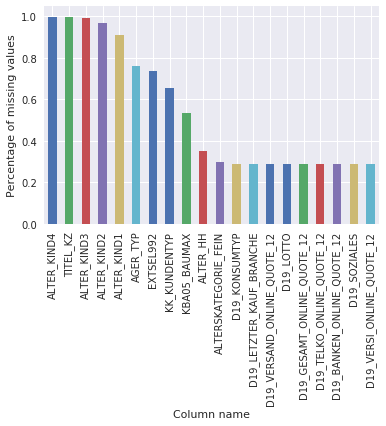

In [17]:
(azdias.isnull().sum()/azdias.shape[0]).sort_values(ascending=False)[:20].plot.bar()
plt.xlabel('Column name')
plt.ylabel('Percentage of missing values');

Now that all the unknown values have been identified we have 9 columns with a large amount of missing values in comparision to the rest of the columns. We are going to drop this nine columns. 

In [18]:
dropcol = ['ALTER_KIND4','ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1', 'TITEL_KZ', 'AGER_TYP', 'EXTSEL992', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
azdias.drop(dropcol, axis=1, inplace=True)
customers.drop(dropcol, axis=1, inplace=True)

**Missing values: by row**

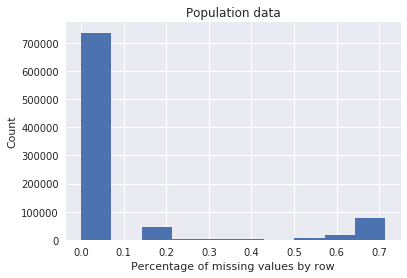

In [19]:
(azdias.isnull().sum(axis=1)/azdias.shape[1]).sort_values(ascending=False).hist()
plt.xlabel('Percentage of missing values by row')
plt.ylabel('Count')
plt.title('Population data');

In [20]:
row_nulls= (azdias.isnull().sum(axis=1)/azdias.shape[1])
print(len(row_nulls[row_nulls > 0.5])/azdias.shape[0])
print(len(row_nulls[row_nulls <= 0.5])/azdias.shape[0])
print(len(row_nulls[row_nulls <= 0.1])/azdias.shape[0])
print(len(row_nulls[row_nulls == 0.0])/azdias.shape[0])

0.11216858669174089
0.8878314133082591
0.827182034534644
0.4139018268196104


89% of the rows have less than 50% missing data and 83% less than 10%. Let see what happens with the customers df before make a decision.

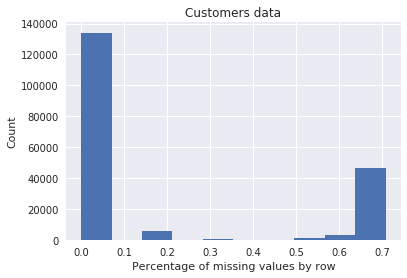

In [21]:
(customers.isnull().sum(axis=1)/customers.shape[1]).sort_values(ascending=False).hist()
plt.xlabel('Percentage of missing values by row')
plt.ylabel('Count')
plt.title('Customers data');

We can see similar behaviors in both data frames, with the difference that for customers we have a lot more of rows on the 70% of missing data. I believe that the best option is to delete all rows with more than 10% of missing data. 

Justification: Since we are going to perform clustering, we will need to fill the missing data with some value. But almost all columns are categorical so we will be filling missing values with something like the mode and, therefore, losing the real information from the dataset. Due to the low percentage of rows with more of 10% missing data, the best option is to drop those rows.

In [22]:
azdias.drop(list(row_nulls[row_nulls > 0.1].index.values),inplace=True)

In [23]:
azdias.shape

(737202, 357)

In [24]:
row_nulls_cust = (customers.isnull().sum(axis=1)/customers.shape[1])

In [25]:
customers.drop(list(row_nulls_cust[row_nulls_cust>0.1].index.values),inplace=True)

In [26]:
customers.shape

(134245, 360)

In [27]:
#Save the clean data frames
azdias.to_csv('azdias_clean.csv',sep=';',index=False)
customers.to_csv('customers_clean.csv',sep=';',index=False)

### Data pre-processing

In [2]:
# Load clean data frames
azdias = pd.read_csv('azdias_clean.csv', sep=';')
customers = pd.read_csv('customers_clean.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
azdias.head(2)

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910220,9.0,NaN,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
1,910225,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3


In [4]:
customers.head(2)

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,1.0,10.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,143872,1.0,6.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4


**Drop extra columns in costumers data**

In [3]:
customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1, inplace=True)

**Manage object columns**

In [29]:
azdias.select_dtypes(include=['object']).head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W
5,8C,8,54,D19_ENERGIE,1992-02-12 00:00:00,W


In [8]:
azdias.CAMEO_DEUG_2015.value_counts()

8.0    58445
8      57692
6.0    45467
6      45096
9.0    44973
9      44423
4.0    43280
4      42778
2.0    34723
3.0    34556
2      34355
3      34111
7.0    32965
7      32343
5.0    22485
5      22363
1.0    15513
1      15313
8.0    12709
6.0    10116
9.0    10041
4.0     9518
3.0     7647
2.0     7525
7.0     7164
5.0     4860
1.0     3402
X        284
Name: CAMEO_DEUG_2015, dtype: int64

In [9]:
azdias.CAMEO_INTL_2015.value_counts()

51.0    57163
51      56553
41.0    39233
41      38939
24.0    38242
24      37962
14.0    26537
14      26255
43.0    24325
43      24196
54.0    19541
54      18992
25.0    16902
25      16481
22.0    13672
22      13511
51.0    12595
45.0    11378
45      11224
13.0    10930
13      10855
55.0     9428
55       9074
23.0     9020
52.0     9018
52       8966
23       8935
41.0     8631
24.0     8395
34.0     7913
        ...  
31       7180
44.0     6250
44       6182
14.0     5677
43.0     5478
12.0     5381
12       5317
35       4421
32       4390
32.0     4304
35.0     4303
54.0     4168
33.0     4117
33       4082
25.0     3794
22.0     3069
13.0     2419
45.0     2417
52.0     2068
55.0     2012
23.0     1907
34.0     1678
15.0     1608
31.0     1592
44.0     1434
12.0     1223
32.0      996
35.0      970
33.0      851
XX        284
Name: CAMEO_INTL_2015, Length: 64, dtype: int64

X and XX means unknown, so first we convert that to NaN and then to numeric

In [4]:
azdias['CAMEO_DEUG_2015'].replace('X',np.NaN, inplace=True)
azdias['CAMEO_INTL_2015'].replace('XX',np.NaN, inplace=True)
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].astype(float)
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].astype(float)

customers['CAMEO_DEUG_2015'].replace('X',np.NaN, inplace=True)
customers['CAMEO_INTL_2015'].replace('XX',np.NaN, inplace=True)
customers['CAMEO_DEUG_2015'] = customers['CAMEO_DEUG_2015'].astype(float)
customers['CAMEO_INTL_2015'] = customers['CAMEO_INTL_2015'].astype(float)

Other columns:

In [14]:
azdias.OST_WEST_KZ.value_counts()

W    582212
O    154990
Name: OST_WEST_KZ, dtype: int64

Since we have only two values we can map them to 0 or 1.

In [5]:
azdias['OST_WEST_KZ'] = azdias.OST_WEST_KZ.map({'W':0,'O':1})
customers['OST_WEST_KZ'] = customers.OST_WEST_KZ.map({'W':0,'O':1})

In [17]:
azdias.select_dtypes(include=['object']).head()

,CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM
0,8A,NaN,1992-02-10 00:00:00
1,4C,D19_UNBEKANNT,1992-02-12 00:00:00
2,2A,D19_UNBEKANNT,1997-04-21 00:00:00
3,6B,D19_SCHUHE,1992-02-12 00:00:00
4,8C,D19_ENERGIE,1992-02-12 00:00:00


The columns D19_LETZTER_KAUF_BRANCHE and EINGEFUEGT_AM  are not in the metadata files. Let's take a look:

In [20]:
azdias.EINGEFUEGT_AM.head()

0    1992-02-10 00:00:00
1    1992-02-12 00:00:00
2    1997-04-21 00:00:00
3    1992-02-12 00:00:00
4    1992-02-12 00:00:00
Name: EINGEFUEGT_AM, dtype: object

In [21]:
azdias.EINGEFUEGT_AM.tail()

737197    1992-02-10 00:00:00
737198    1992-02-10 00:00:00
737199    1992-02-10 00:00:00
737200    1992-02-12 00:00:00
737201    1992-02-10 00:00:00
Name: EINGEFUEGT_AM, dtype: object

In [23]:
#Covert to datetime to have more information:
pd.to_datetime(azdias.EINGEFUEGT_AM).describe()

count                  737202
unique                   2819
top       1992-02-10 00:00:00
freq                   372205
first     1991-06-17 00:00:00
last      2005-05-11 00:00:00
Name: EINGEFUEGT_AM, dtype: object

I'm keeping only the year of this date. Justification: I can use it as a numerical column and the month and date probably don't mean anything in this context.

In [6]:
azdias['year'] = pd.DatetimeIndex(azdias['EINGEFUEGT_AM']).year
customers['year'] = pd.DatetimeIndex(customers['EINGEFUEGT_AM']).year

In [7]:
azdias.drop('EINGEFUEGT_AM', axis=1, inplace=True)
customers.drop('EINGEFUEGT_AM', axis=1, inplace=True)

Other object columns:

In [19]:
azdias.D19_LETZTER_KAUF_BRANCHE.value_counts()

D19_UNBEKANNT             179081
D19_VERSICHERUNGEN         52220
D19_SONSTIGE               40546
D19_VOLLSORTIMENT          31292
D19_SCHUHE                 28486
D19_BUCH_CD                25643
D19_VERSAND_REST           23398
D19_DROGERIEARTIKEL        21371
D19_BANKEN_DIREKT          20992
D19_BEKLEIDUNG_REST        19147
D19_HAUS_DEKO              18823
D19_TELKO_MOBILE           13194
D19_ENERGIE                11146
D19_TELKO_REST             10478
D19_BANKEN_GROSS            9558
D19_BEKLEIDUNG_GEH          9173
D19_KINDERARTIKEL           6416
D19_FREIZEIT                6404
D19_TECHNIK                 6282
D19_LEBENSMITTEL            5814
D19_BANKEN_REST             4709
D19_RATGEBER                4483
D19_NAHRUNGSERGAENZUNG      3731
D19_DIGIT_SERV              3273
D19_REISEN                  2808
D19_TIERARTIKEL             2294
D19_SAMMELARTIKEL           2243
D19_HANDWERK                2033
D19_WEIN_FEINKOST           1965
D19_GARTEN                  1486
D19_BANKEN

In [31]:
azdias.CAMEO_DEU_2015.value_counts()

6B    53999
8A    50767
4C    43986
2D    32902
7A    32625
3C    32562
3D    32173
8B    31261
4A    30252
8C    30145
9D    26742
9B    25884
9C    22918
7B    22917
9A    20052
2C    17740
8D    16673
6E    15597
5D    14068
2B    14040
6C    13866
2A    11921
1D    11455
1A    10164
5A     9720
5B     9690
5C     9050
4B     8283
7C     8126
4D     8051
6A     6414
3A     5870
6D     5755
3B     5709
6F     5048
4E     5004
1E     4782
7D     4430
7E     4374
1C     4012
5F     3939
9E     3841
1B     3815
5E     3241
XX      284
Name: CAMEO_DEU_2015, dtype: int64

In [8]:
#XX means unknown:
azdias['CAMEO_DEU_2015'].replace('XX',np.NaN, inplace=True)
customers['CAMEO_DEU_2015'].replace('XX',np.NaN, inplace=True)

In [33]:
azdias.CAMEO_DEU_2015.isnull().sum()

3339

D19_LETZTER_KAUF_BRANCHE and CAMEO_DEU_2015 columns have categorical data that is not ordinal. Solution: One-hot encoding

In [9]:
azdias = pd.get_dummies(azdias, columns=['D19_LETZTER_KAUF_BRANCHE', 'CAMEO_DEU_2015'])
customers = pd.get_dummies(customers, columns=['D19_LETZTER_KAUF_BRANCHE', 'CAMEO_DEU_2015'])

In [10]:
azdias.select_dtypes(include=['object']).head(2)

""
0
1


Now we have all numeric columns

**Fill missing values**

We need to fill the few missing values left in the data. Since data is categorical we fill the missing values wit the mode.

In [20]:
imputer = Imputer(strategy='most_frequent')

In [12]:
azdias_col = list(azdias.columns.values)
azdias_imp = imputer.fit_transform(azdias)
azdias = pd.DataFrame(azdias_imp, columns= azdias_col)

In [21]:
customers_col = list(customers.columns.values)
customers_imp = imputer.fit_transform(customers)
customers = pd.DataFrame(customers_imp, columns = customers_col)

In [14]:
#check
print(azdias.isnull().any().sum())
print(customers.isnull().any().sum())

0
0


In [15]:
azdias.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
0,910220.0,9.0,18.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,910225.0,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,910226.0,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,910241.0,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,910244.0,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
customers.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
0,9626.0,1.0,10.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,143872.0,1.0,6.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,143873.0,1.0,8.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,143874.0,1.0,20.0,14.0,7.0,0.0,0.0,4.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,143888.0,1.0,11.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
azdias.shape, customers.shape

((737202, 434), (134245, 434))

In [23]:
#Save the data frames
azdias.to_csv('azdias_numeric_filled.csv',sep=';',index=False)
customers.to_csv('customers_numeric_filled.csv',sep=';',index=False)

**Drop correlated columns**

In [3]:
# Load clean data frames
azdias = pd.read_csv('azdias_numeric_filled.csv', sep=';')
customers = pd.read_csv('customers_numeric_filled.csv', sep=';')

In [4]:
azdias.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
0,910220.0,9.0,18.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,910225.0,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,910226.0,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,910241.0,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,910244.0,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


I follow the steps on https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/ 

But before delete the columns I check that the high correlation holds on both data frames.

In [5]:
corr_matrix = azdias.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop

['ANZ_STATISTISCHE_HAUSHALTE',
 'CAMEO_INTL_2015',
 'D19_VERSAND_ONLINE_DATUM',
 'KBA13_HERST_SONST',
 'KBA13_KMH_250',
 'LP_FAMILIE_GROB',
 'LP_LEBENSPHASE_GROB',
 'LP_STATUS_GROB',
 'PLZ8_GBZ',
 'PLZ8_HHZ']

In [14]:
corr_matrix = customers.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop2 = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop2

['ANZ_STATISTISCHE_HAUSHALTE',
 'CAMEO_INTL_2015',
 'KBA13_HERST_SONST',
 'KBA13_KMH_250',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'LP_STATUS_GROB',
 'PLZ8_GBZ',
 'PLZ8_HHZ']

In [15]:
drop = list(set(to_drop).intersection(set(to_drop2)))
drop

['KBA13_HERST_SONST',
 'PLZ8_GBZ',
 'PLZ8_HHZ',
 'CAMEO_INTL_2015',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'LP_LEBENSPHASE_GROB',
 'LP_STATUS_GROB',
 'KBA13_KMH_250']

In [16]:
azdias.drop(drop,axis=1,inplace=True)

In [17]:
customers.drop(drop,axis=1,inplace=True)

In [18]:
azdias.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
0,9.0,18.0,21.0,11.0,0.0,0.0,2.0,0.0,3.0,6.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.0,17.0,17.0,10.0,0.0,0.0,1.0,0.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,13.0,13.0,1.0,0.0,0.0,0.0,0.0,2.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,20.0,14.0,3.0,0.0,0.0,4.0,0.0,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,10.0,10.0,5.0,0.0,0.0,1.0,0.0,2.0,6.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
customers.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
0,9626.0,1.0,10.0,10.0,1.0,0.0,0.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,143872.0,1.0,6.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,143873.0,1.0,8.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,143874.0,1.0,20.0,14.0,7.0,0.0,0.0,4.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,143888.0,1.0,11.0,10.0,1.0,0.0,0.0,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Drop id column**

In [ ]:
azdias.drop('LNR',axis=1,inplace=True)

In [21]:
customers.drop('LNR',axis=1,inplace=True)

**Scale the data**

The scaler is not in the clean_data funtion!

In [22]:
azdias_list = list(azdias.columns.values)
scaler = StandardScaler()
azdias = scaler.fit_transform(azdias)
azdias = pd.DataFrame(azdias,columns=azdias_list)
azdias.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
0,1.262263,0.565416,1.560778,0.186872,-0.125305,-0.299076,0.224663,-0.060664,-0.183307,0.849580,...,-0.077257,3.677130,-0.210435,-0.206481,-0.152118,-0.167214,-0.190758,-0.179124,-0.194011,-0.072371
1,1.262263,0.275057,0.674371,0.120680,-0.125305,-0.299076,-0.634503,-0.060664,-0.183307,-0.980519,...,-0.077257,-0.271951,-0.210435,-0.206481,-0.152118,-0.167214,-0.190758,-0.179124,-0.194011,-0.072371
2,-0.934307,-0.886380,-0.212037,-0.475044,-0.125305,-0.299076,-1.493669,-0.060664,-1.187438,-0.065470,...,-0.077257,-0.271951,-0.210435,-0.206481,-0.152118,-0.167214,-0.190758,-0.179124,-0.194011,-0.072371
3,-0.934307,1.146134,0.009565,-0.342661,-0.125305,-0.299076,1.942996,-0.060664,0.820825,-0.980519,...,-0.077257,-0.271951,-0.210435,-0.206481,-0.152118,-0.167214,-0.190758,-0.179124,-0.194011,-0.072371
4,-0.934307,-1.757458,-0.876842,-0.210278,-0.125305,-0.299076,-0.634503,-0.060664,-1.187438,0.849580,...,-0.077257,-0.271951,-0.210435,4.843057,-0.152118,-0.167214,-0.190758,-0.179124,-0.194011,-0.072371


In [23]:
customers_list = list(customers.columns.values)

# we have to apply the same scaler to the customer data
customers = scaler.transform(customers)
customers = pd.DataFrame(customers,columns=customers_list)
customers.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
0,-0.934307,-1.757458,-0.876842,-0.475044,-0.125305,-0.299076,0.224663,-0.060664,-2.191569,-0.522994,...,-0.077257,-0.271951,-0.210435,-0.206481,-0.152118,-0.167214,-0.190758,-0.179124,-0.194011,-0.072371
1,-0.934307,-2.918894,-3.092861,-0.475044,-0.125305,-0.299076,-0.634503,-0.060664,-0.183307,1.307105,...,-0.077257,-0.271951,-0.210435,-0.206481,-0.152118,-0.167214,-0.190758,-0.179124,-0.194011,-0.072371
2,-0.934307,-2.338176,-1.320046,-0.541236,-0.125305,-0.299076,-1.493669,-0.060664,-2.191569,1.307105,...,-0.077257,-0.271951,-0.210435,-0.206481,-0.152118,-0.167214,-0.190758,-0.179124,-0.194011,-0.072371
3,-0.934307,1.146134,0.009565,-0.077895,-0.125305,-0.299076,1.942996,-0.060664,-0.183307,-0.522994,...,-0.077257,-0.271951,-0.210435,-0.206481,-0.152118,-0.167214,-0.190758,-0.179124,-0.194011,-0.072371
4,-0.934307,-1.467098,-0.876842,-0.475044,-0.125305,-0.299076,0.224663,-0.060664,-0.183307,1.307105,...,-0.077257,-0.271951,-0.210435,-0.206481,-0.152118,-0.167214,-0.190758,-0.179124,-0.194011,-0.072371


In [24]:
azdias.shape, customers.shape

((737202, 425), (134245, 425))

In [25]:
#Save the data frames
azdias.to_csv('azdias_pre_proc.csv',sep=';',index=False)
customers.to_csv('customers_pre_proc.csv',sep=';',index=False)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [25]:
# Load clean data frames
azdias = pd.read_csv('azdias_pre_proc.csv', sep=';')
#customers = pd.read_csv('customers_pre_proc.csv', sep=';')

### Principal component analysis

Since we still have a lot of columns, we will start by doing a principal component analysis.

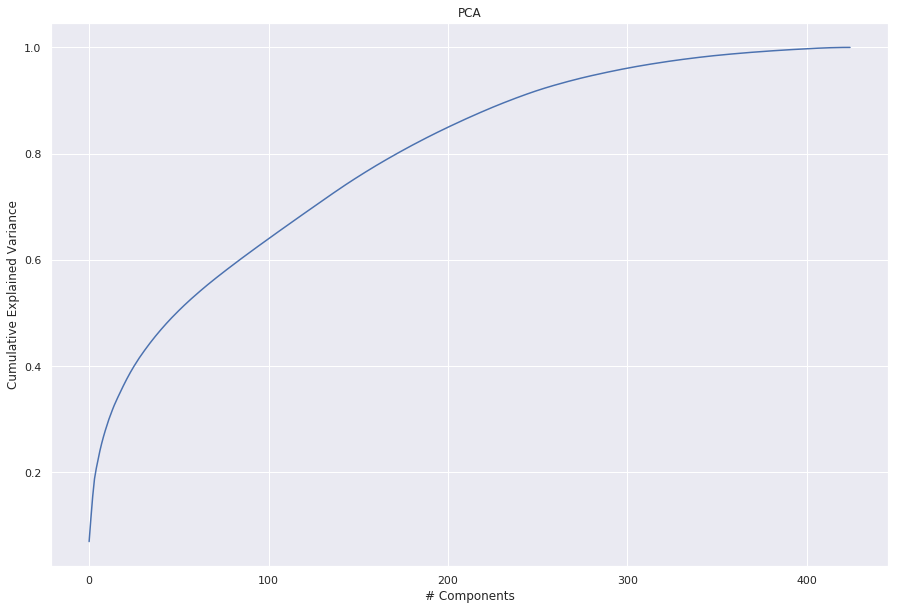

In [28]:
pca = PCA().fit(azdias)
plt.figure(figsize=(15,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('# Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA');

In [33]:
pca_cum = pca.explained_variance_ratio_.tolist()
print(np.sum(pca_cum[:170]))

0.795251474505345


Using 170 components we can explain around 80% of the variance. This reduced the dimensionalty to less than a half of what we had. 

In [26]:
n=170
pca_red = PCA(n_components=n).fit(azdias)
azdias_red = pd.DataFrame(pca_red.transform(azdias))

In [49]:
#Save the data frames
azdias_red.to_csv('azdias_red.csv',sep=';',index=False)

**Interpretation of principal components**

We can take a look to how the firsts PC relates with the columns

In [77]:
azdias_list = list(azdias.columns.values)

In [118]:
weights = pd.DataFrame(pca_red.components_, columns=azdias_list)
print(pca_red.explained_variance_ratio_[0])
weights.loc[0].sort_values(ascending=False)[:5]

0.06938872109477491


MOBI_REGIO        0.135321
PLZ8_ANTG1        0.128183
KBA13_ANTG1       0.127602
KBA05_ANTG1       0.125131
LP_STATUS_FEIN    0.124294
Name: 0, dtype: float64

In [119]:
weights.loc[0].sort_values(ascending=False)[-5:]

KBA13_BAUMAX         -0.121547
HH_EINKOMMEN_SCORE   -0.122055
KBA13_ANTG4          -0.122270
KBA13_ANTG3          -0.126939
PLZ8_ANTG3           -0.127510
Name: 0, dtype: float64

In [79]:
print(pca_red.explained_variance_ratio_[1])
weights.loc[1].sort_values(ascending=False)[:5]

0.04421691744517746


ONLINE_AFFINITAET        0.151081
PRAEGENDE_JUGENDJAHRE    0.141194
CJT_TYP_2                0.140683
D19_GESAMT_ANZ_24        0.139781
FINANZ_SPARER            0.138123
Name: 1, dtype: float64

In [121]:
weights.loc[1].sort_values(ascending=False)[-5:]

CJT_TYP_4                  -0.130736
D19_VERSAND_ONLINE_DATUM   -0.131135
FINANZ_VORSORGER           -0.131248
CJT_TYP_5                  -0.134606
D19_GESAMT_ONLINE_DATUM    -0.136007
Name: 1, dtype: float64

In [81]:
print(pca_red.explained_variance_ratio_[2])
weights.loc[2].sort_values(ascending=False)[:5]

0.04115257647966543


KBA13_HERST_BMW_BENZ           0.182109
KBA13_SEG_OBEREMITTELKLASSE    0.157082
KBA13_MERCEDES                 0.155426
KBA13_BMW                      0.152144
KBA13_SITZE_4                  0.147525
Name: 2, dtype: float64

In [122]:
weights.loc[2].sort_values(ascending=False)[-5:]

KBA13_HALTER_20        -0.115831
KBA13_HALTER_25        -0.120407
KBA13_KMH_140_210      -0.125044
KBA13_SEG_KLEINWAGEN   -0.129938
KBA13_SITZE_5          -0.151314
Name: 2, dtype: float64

### Clustering

We will perform the clustering with the k-means algorith. We need to find how many clusters is convenient to consider. Since the complete dataframe is too long I will take a sample to sarch for k.

In [4]:
# Load clean data frames
azdias_red = pd.read_csv('azdias_red.csv', sep=';')

In [12]:
sample_azd = azdias_red.sample(30000)
k_list = range(2,22)
score_list = [KMeans(n_clusters=k).fit(sample_azd).score(sample_azd) for k in k_list]

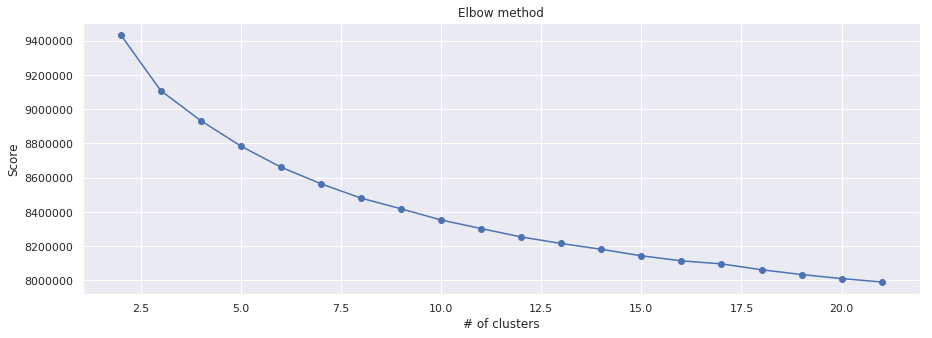

In [16]:
plt.figure( figsize=(15,5))
plt.plot(k_list, abs(np.array(score_list)), linestyle='-', marker='o')
plt.title('Elbow method')
plt.xlabel('# of clusters')
plt.ylabel('Score');

We use the elbow method: from cluster # 16 , the score flattens and that is the most convinient amount of clusters.

In [17]:
k = 16
kmeans_model = KMeans(n_clusters=k)
kmeans_fitted = kmeans_model.fit(azdias_red)
azdias_clust = kmeans_fitted.predict(azdias_red)
azdias_clustered = pd.DataFrame(azdias_clust, columns = ['cluster'])

In [18]:
azdias_clustered.head()

,cluster
0,5
1,13
2,2
3,11
4,12


In [19]:
azdias_clustered.to_pickle('azdias_clustered')

### Customers data

We apply the same fitted models to the customer data.

In [27]:
customers_red = pd.DataFrame(pca_red.transform(customers))
customers_red.to_pickle('customers_red')

In [28]:
customers_clust = kmeans_fitted.predict(customers_red)
customers_clustered = pd.DataFrame(customers_clust, columns = ['cluster'])

In [29]:
customers_clustered.head()

,cluster
0,12
1,12
2,2
3,1
4,10


In [30]:
customers_clustered.to_pickle('customers_clustered')

### Comparision between clusters 

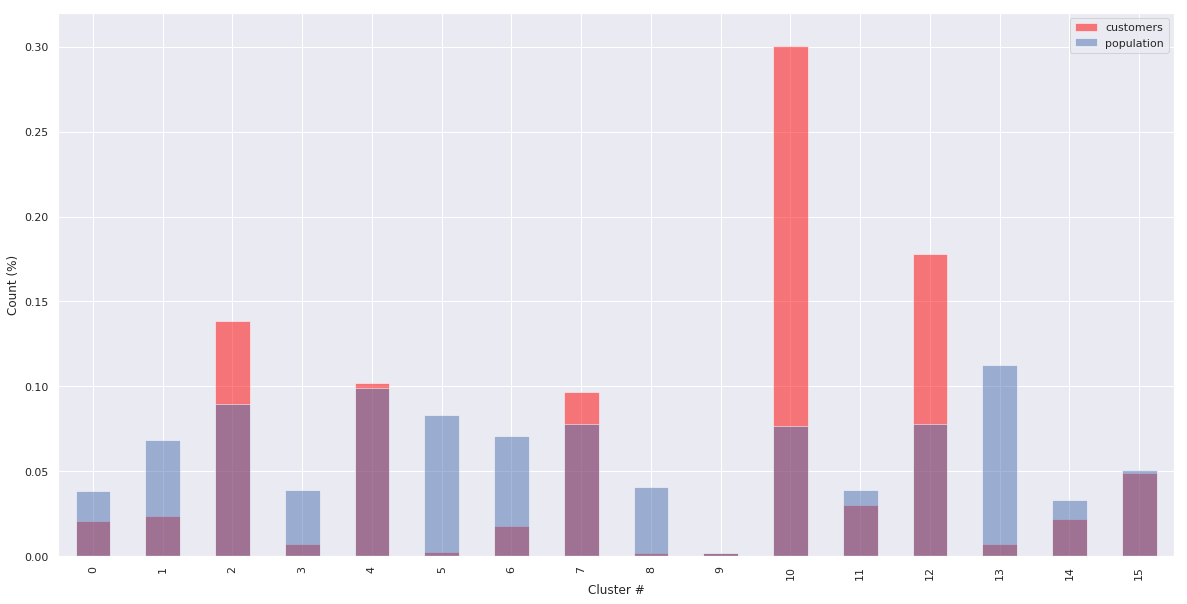

In [58]:
plt.figure(figsize=(20,10))
(customers_clustered.cluster.value_counts().sort_index()/customers_clustered.shape[0]).plot.bar(alpha=0.5,color='red', label='customers')
(azdias_clustered.cluster.value_counts().sort_index()/azdias_clustered.shape[0]).plot.bar(alpha=0.5, label = 'population')
plt.ylim([0,0.32])
plt.legend()
plt.xlabel('Cluster #')
plt.ylabel('Count (%)');

It's clear that the customer sub-population is represented by the clusters 10, 12 and 2 principally. People in this three clusters are the company's target. Which PC are associated with this clusters? And with the most underrepresented (13, 5, 6, 8) ?

In [100]:
weights_10 = kmeans_fitted.cluster_centers_[10]
weights_12 = kmeans_fitted.cluster_centers_[12]
weights_2 = kmeans_fitted.cluster_centers_[2]

weights_13 = kmeans_fitted.cluster_centers_[13]
weights_5 = kmeans_fitted.cluster_centers_[5]
weights_6 = kmeans_fitted.cluster_centers_[6]
weights_8 = kmeans_fitted.cluster_centers_[8]

components = list(range(0, 170))

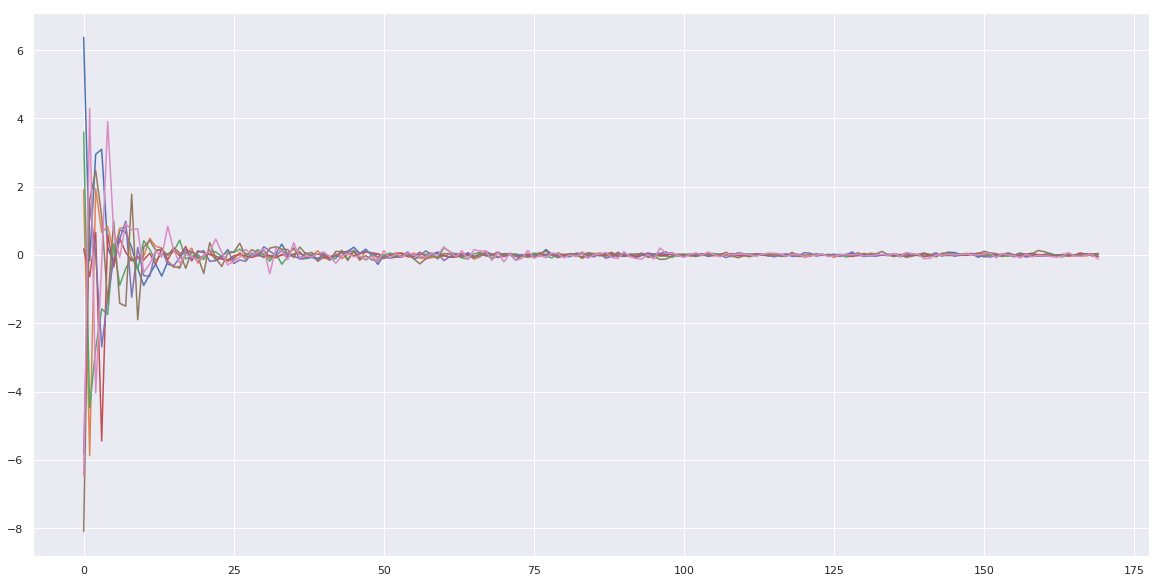

In [101]:
plt.figure(figsize=(20,10))
plt.plot(components, weights_10)
plt.plot(components, weights_12)
plt.plot(components, weights_2)
plt.plot(components, weights_13)
plt.plot(components, weights_5)
plt.plot(components, weights_6)
plt.plot(components, weights_8);

zoom in:

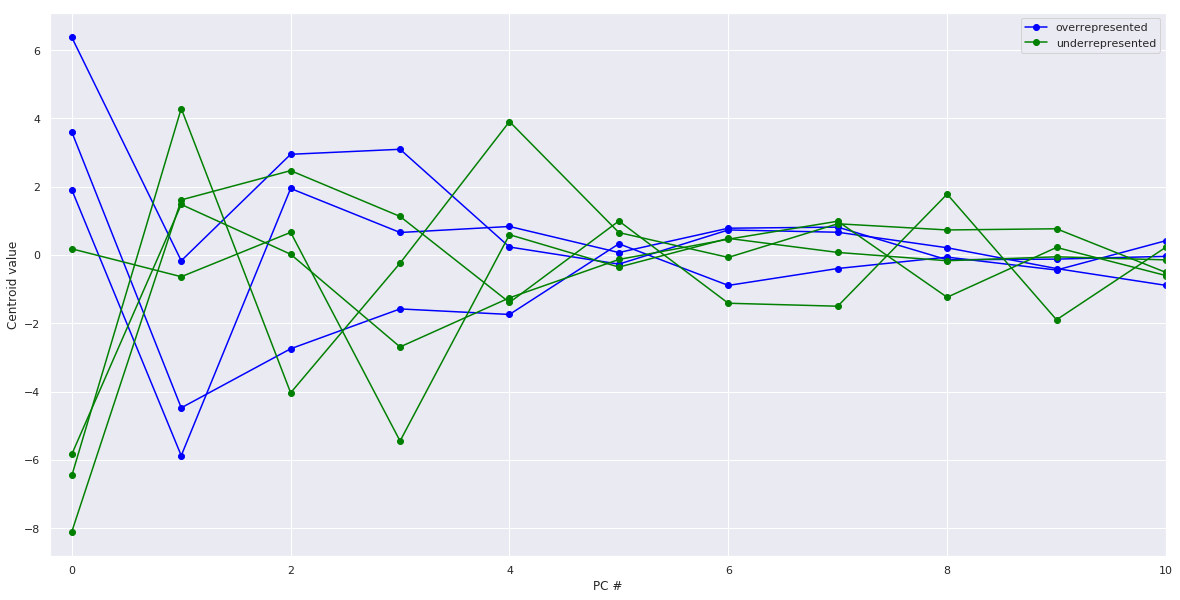

In [117]:
plt.figure(figsize=(20,10))
plt.plot(components, weights_10, color = 'blue', marker='o', label='overrepresented')
plt.plot(components, weights_12, color = 'blue', marker='o')
plt.plot(components, weights_2, color = 'blue', marker='o')
plt.plot(components, weights_13, color = 'green', marker='o',  label='underrepresented')
plt.plot(components, weights_5, color = 'green', marker='o')
plt.plot(components, weights_6, color = 'green', marker='o')
plt.plot(components, weights_8, color = 'green', marker='o')
plt.xlim(-0.2,10)
plt.legend()
plt.ylabel('Centroid value')
plt.xlabel('PC #');

It's really difficult to do an exhaustive analysis of the situation but there is one clear conclusion:

For the Principal component # 0 all the underrepresented clusters have a value less than 1 and the overrepresented have a bigger value. Almost the opossite happens for the PC # 1.

As we have seen before, the PC # 0 is most related with the columns: MOBI_REGIO,  PLZ8_ANTG1, KBA13_ANTG1, KBA05_ANTG1, LP_STATUS_FEIN, KBA13_BAUMAX, HH_EINKOMMEN_SCORE, KBA13_ANTG4, KBA13_ANTG3, PLZ8_ANTG3

Let's take a look on how this features differs for a large or low value of PC # 0

In [131]:
columns_pc0 = ['MOBI_REGIO', 'PLZ8_ANTG1', 'KBA13_ANTG1', 'KBA05_ANTG1', 'LP_STATUS_FEIN', 'KBA13_BAUMAX', 'HH_EINKOMMEN_SCORE', 'KBA13_ANTG4', 'KBA13_ANTG3', 'PLZ8_ANTG3']
azdias_sub = azdias[columns_pc0]

In [132]:
azdias_sub['pc0'] = azdias_red[0]

/home/caro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [160]:
azdias_down = azdias_sub[azdias_sub.pc0 < 1.0]
azdias_down.drop('pc0',axis=1,inplace=True)

/home/caro/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [161]:
azdias_up = azdias_sub[azdias_sub.pc0 >= 1.0]
azdias_up.drop('pc0',axis=1,inplace=True)

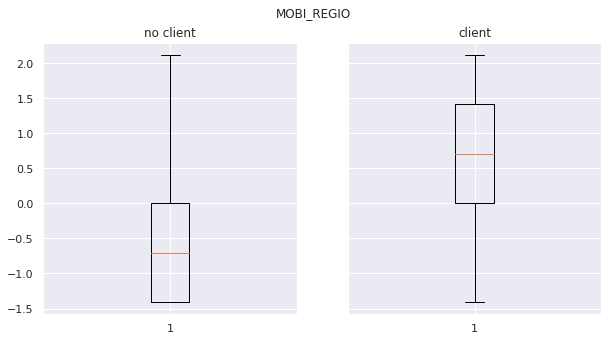

In [201]:
fig, ax = plt.subplots(1,2,figsize=(10,5),sharey=True)
ax[0].set_title('no client')
ax[0].boxplot(azdias_down.MOBI_REGIO)
ax[1].set_title('client')
ax[1].boxplot(azdias_up.MOBI_REGIO)
fig.suptitle('MOBI_REGIO');

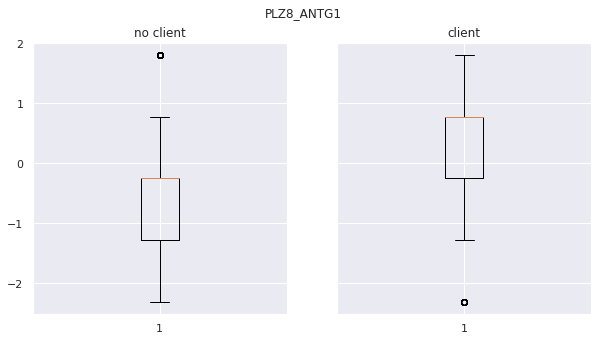

In [202]:
fig, ax = plt.subplots(1,2,figsize=(10,5),sharey=True)
ax[0].set_title('no client')
ax[0].boxplot(azdias_down.PLZ8_ANTG1)
ax[1].set_title('client')
ax[1].boxplot(azdias_up.PLZ8_ANTG1)
fig.suptitle('PLZ8_ANTG1');

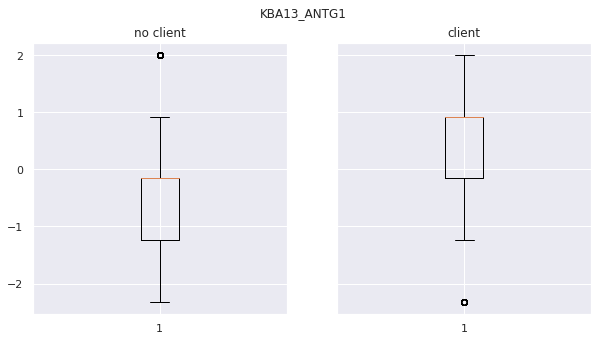

In [203]:
fig, ax = plt.subplots(1,2,figsize=(10,5),sharey=True)
ax[0].set_title('no client')
ax[0].boxplot(azdias_down.KBA13_ANTG1)
ax[1].set_title('client')
ax[1].boxplot(azdias_up.KBA13_ANTG1)
fig.suptitle('KBA13_ANTG1');

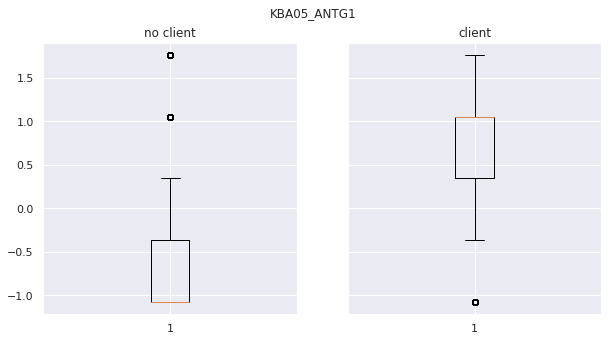

In [204]:
fig, ax = plt.subplots(1,2,figsize=(10,5),sharey=True)
ax[0].set_title('no client')
ax[0].boxplot(azdias_down.KBA05_ANTG1)
ax[1].set_title('client')
ax[1].boxplot(azdias_up.KBA05_ANTG1)
fig.suptitle('KBA05_ANTG1');

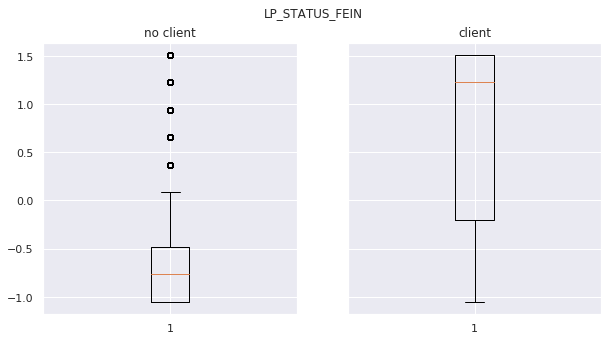

In [205]:
fig, ax = plt.subplots(1,2,figsize=(10,5),sharey=True)
ax[0].set_title('no client')
ax[0].boxplot(azdias_down.LP_STATUS_FEIN)
ax[1].set_title('client')
ax[1].boxplot(azdias_up.LP_STATUS_FEIN)
fig.suptitle('LP_STATUS_FEIN');

For all the previous features in general we can associate positive values with clients and negative values with no clients. Since all this features are scaled to mean=0 the this means values above and under the mean.

- The MOBI_REGIO column is related with the mobility, high values (clients) indicates low mobility.
- The PLZ8_ANTG1 column indicates the number of 1-2 family houses in PLZ8 (similar to zipcode), high values (clients) indicates more houses.
- The KBA05_ANTG1 column is the same but by cell.
- The LP_STATUS_FEIN column is related with social status, high values (clients) indicates better status.

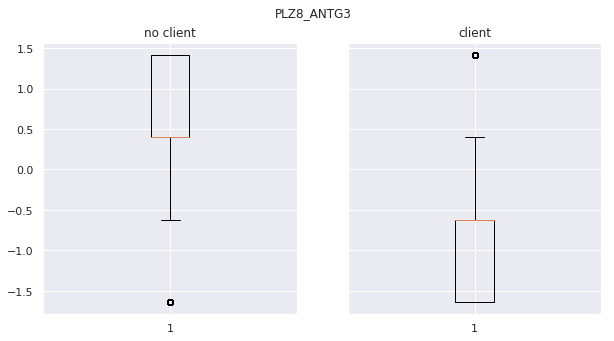

In [212]:
fig, ax = plt.subplots(1,2,figsize=(10,5),sharey=True)
ax[0].set_title('no client')
ax[0].boxplot(azdias_down.PLZ8_ANTG3)
ax[1].set_title('client')
ax[1].boxplot(azdias_up.PLZ8_ANTG3)
fig.suptitle('PLZ8_ANTG3');

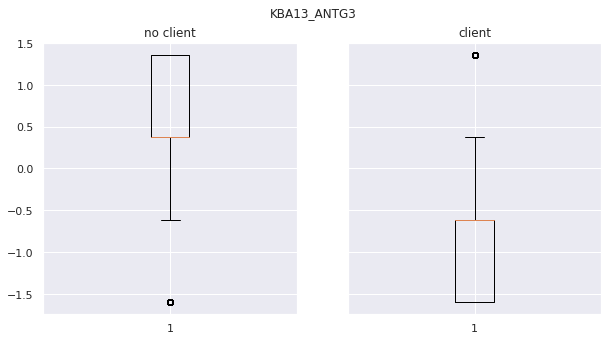

In [211]:
fig, ax = plt.subplots(1,2,figsize=(10,5),sharey=True)
ax[0].set_title('no client')
ax[0].boxplot(azdias_down.KBA13_ANTG3)
ax[1].set_title('client')
ax[1].boxplot(azdias_up.KBA13_ANTG3)
fig.suptitle('KBA13_ANTG3');

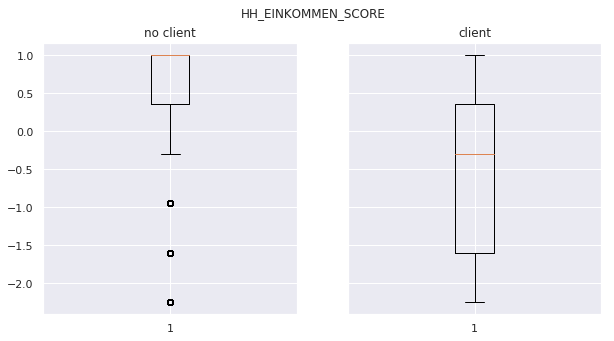

In [208]:
fig, ax = plt.subplots(1,2,figsize=(10,5),sharey=True)
ax[0].set_title('no client')
ax[0].boxplot(azdias_down.HH_EINKOMMEN_SCORE)
ax[1].set_title('client')
ax[1].boxplot(azdias_up.HH_EINKOMMEN_SCORE)
fig.suptitle('HH_EINKOMMEN_SCORE');

For this three features the opposity ocurs.

- The columns PLZ8_ANTG3 and KBA13_ANTG3 indicates the amount of 6-10 family houses, low values (clients) indicates few houses. 
- The HH_EINKOMMEN_SCORE indicates income, low values (clients) are the highest incomes.

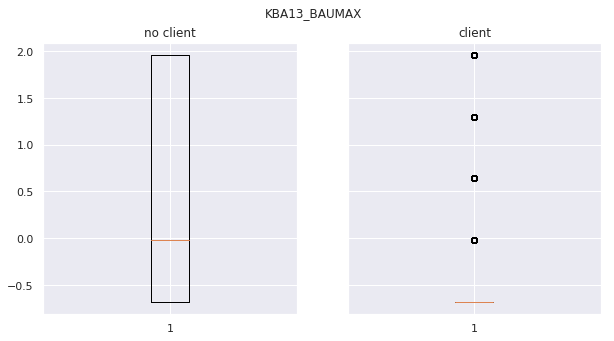

In [206]:
fig, ax = plt.subplots(1,2,figsize=(10,5),sharey=True)
ax[0].set_title('no client')
ax[0].boxplot(azdias_down.KBA13_BAUMAX)
ax[1].set_title('client')
ax[1].boxplot(azdias_up.KBA13_BAUMAX)
fig.suptitle('KBA13_BAUMAX');

In [207]:
azdias_up.KBA13_BAUMAX.describe()

count    320153.000000
mean         -0.589989
std           0.382738
min          -0.682538
25%          -0.682538
50%          -0.682538
75%          -0.682538
max           1.961795
Name: KBA13_BAUMAX, dtype: float64

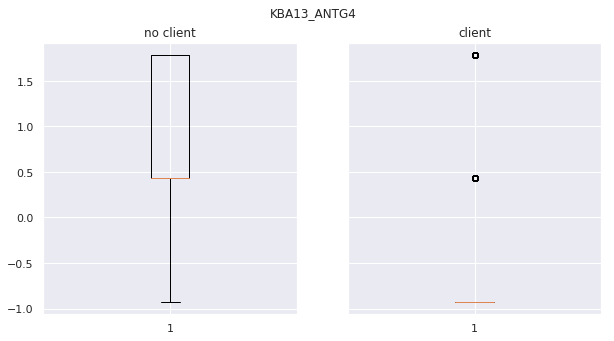

In [210]:
fig, ax = plt.subplots(1,2,figsize=(10,5),sharey=True)
ax[0].set_title('no client')
ax[0].boxplot(azdias_down.KBA13_ANTG4)
ax[1].set_title('client')
ax[1].boxplot(azdias_up.KBA13_ANTG4)
fig.suptitle('KBA13_ANTG4');

For this last two features we have a very narrow value for clients. This columns are not in the metadata so I don't know their meanning.

**Conclusion**

We are looking for people with high income, high social status, low mobility and a neighborhood with houses of 1-2 families.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

**Clean data**

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [5]:
mailout_train = pd.read_csv('mailout_train.csv', sep=';')

/home/caro/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
train_clean = clean_df4(mailout_train)

/home/caro/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [7]:
train_clean.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
0,1.0,8.0,8.0,15.0,0.0,0.0,1.0,0.0,3.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,13.0,13.0,1.0,0.0,0.0,2.0,0.0,2.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,9.0,7.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,6.0,6.0,4.0,0.0,0.0,2.0,0.0,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,9.0,9.0,53.0,0.0,0.0,1.0,0.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
train_clean.shape

(33834, 426)

**Separate features from target**

In [9]:
y_train = train_clean['RESPONSE']

In [10]:
X_train = train_clean.drop('RESPONSE',axis=1)

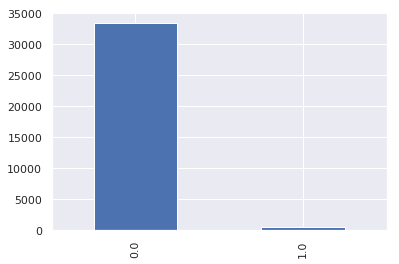

In [11]:
y_train.value_counts().plot.bar();

Since the data is very imbalanced I will not going to split it in train and validation data. I will work only with train data and then see what happens in Part 3 with test data.

Also, due to the imbalance, we will not be using accuracy as metric. Insted, we will use roc_auc to evaluate the performance of the models (this is the metric that will be used in the kaggle step).

**Scale the data**

In [12]:
X_cols = list(X_train.columns.values)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train,columns=X_cols)
X_train.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
0,-0.291009,-0.942955,-0.420558,0.570479,-0.128464,-0.221426,-0.757382,-0.091173,-0.045285,0.336489,...,-0.104285,-0.220002,-0.169785,-0.1957,-0.185712,-0.117402,-0.123217,-0.111028,-0.138744,-0.087144
1,1.489248,0.281558,0.739963,-0.372537,-0.128464,-0.221426,-0.024918,-0.091173,-1.011964,0.336489,...,-0.104285,-0.220002,-0.169785,-0.1957,-0.185712,-0.117402,-0.123217,-0.111028,-0.138744,-0.087144
2,-0.291009,-0.698052,-0.652662,-0.439895,-0.128464,-0.221426,-1.489846,-0.091173,0.921393,-1.487555,...,-0.104285,-0.220002,-0.169785,-0.1957,-0.185712,-0.117402,-0.123217,-0.111028,-0.138744,-0.087144
3,-0.291009,-1.432760,-0.884766,-0.170462,-0.128464,-0.221426,-0.024918,-0.091173,0.921393,-1.031544,...,-0.104285,-0.220002,-0.169785,-0.1957,-0.185712,-0.117402,-0.123217,-0.111028,-0.138744,-0.087144
4,-0.291009,-0.698052,-0.188453,3.130094,-0.128464,-0.221426,-0.757382,-0.091173,-0.045285,-0.119522,...,-0.104285,-0.220002,-0.169785,-0.1957,-0.185712,-0.117402,-0.123217,-0.111028,-0.138744,-0.087144


**Different models**

First, I will test a few simple different models

In [14]:
logreg = LogisticRegression(n_jobs=-1)
svc = SVC()
random = RandomForestClassifier(n_jobs=-1)
gbc = GradientBoostingClassifier()
mlp = MLPClassifier()

In [15]:
class_list = [logreg,svc,random,gbc,mlp]
for model in class_list:
        time_0 = time.time()
        grid = GridSearchCV(estimator=model, param_grid={}, scoring='roc_auc', cv=5, n_jobs=-1)
        grid.fit(X_train, y_train)
        time_1 = time.time()
        print(model, grid.best_score_, round(time_1-time_0))
        #print(grid.best_estimator_)

/home/caro/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/caro/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=None, solver='warn', tol=0.0001,
          verbose=0, warm_start=False) 0.6680441897512686 49
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False) 0.6400150780139727 1590


/home/caro/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 0.5146161093061391 4
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False) 0.770525

The best metric corresponds to the GradientBoostingClassifier and the time that takes is reasonable.

**Improve the best model**

In [17]:
param_grid = {'max_depth': [3,4,5],
             'loss':['deviance', 'exponential'],
             'n_estimators': [100, 150, 200]}

best = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1)
best.fit(X_train, y_train)

print(best.best_score_,best.best_estimator_)

0.7790022316247631 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


The model improves a little when we choose max_depth=4, loss='deviance' and n_estimators = 100

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [ ]:
mailout_test = pd.read_csv('mailout_test.csv', sep=';')

In [ ]:
LNR_test = mailout_test['LNR']

In [ ]:
test_clean = clean_df4(mailout_test, del_rows=False)
test_cols = list(test_clean.columns.values)

In [ ]:
X_test = scaler.transform(test_clean)
X_test = pd.DataFrame(X_test, columns = test_cols)